In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import pyqtorch.modules as pyq

## Solve MIS for QAOA

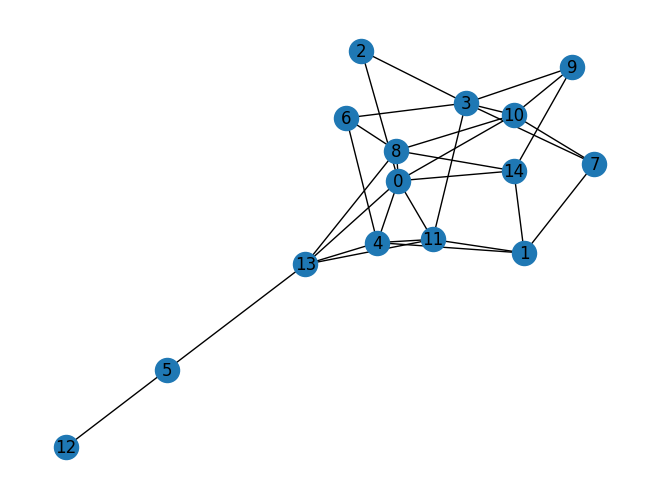

In [46]:
np.random.seed(0)
n_nodes = 10

graph = nx.gnp_random_graph(n_nodes, .25, seed=42)
nx.draw(graph, with_labels=True)

In [47]:
from pyqtorch.matrices import generate_ising_from_graph, sum_N

ising_matrix = generate_ising_from_graph(graph, type_ising='N')
ising_cost = 1.2*ising_matrix - sum_N(n_nodes)

ising_matrix = ising_matrix.reshape([2] * n_nodes + [1])
ising_cost = ising_cost.reshape([2] * n_nodes + [1])


class MIS(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.gamma = nn.Parameter(torch.empty(n_layers,))
        self.ansatz = pyq.VariationalLayer(n_qubits, pyq.RX)
        self.reset_parameters()
        
    def reset_parameters(self):
        init.uniform_(self.gamma, -2 * np.pi, 2 * np.pi)
        self.ansatz.reset_parameters()
        
    def forward(self, return_cost=False):
        state = pyq.uniform_state(self.n_qubits)
        for g in self.gamma:
            state = state * torch.exp(-1j * g * ising_matrix)
            state = self.ansatz(state)
        if return_cost:
            return torch.real(torch.sum(torch.abs(state)**2 * ising_cost))
        else:
            state = state.reshape((2**self.n_qubits,))
            return torch.abs(state)**2

In [48]:
model = MIS(n_nodes, 20)

optimizer = torch.optim.Adam(model.parameters(), lr=.02)
epochs = 100


for epoch in range(epochs):
    optimizer.zero_grad()
    loss = model(True)
    loss.backward()
    optimizer.step()
    if epoch%50 == 0:
        print(f"Epoch {epoch} | Loss {loss}")

Epoch 0 | Loss 1.4900727366440991
Epoch 50 | Loss 1.1838491896514012


In [49]:
prob = model()
mis = torch.argmax(prob)
format(mis, '010b')

'1111101000'

In [50]:
mis

tensor(1000)

In [51]:
"{0:b}".format(1)

'1'

In [52]:
sum_N(n_nodes)[mis]

tensor(6.+0.j, dtype=torch.complex128)